### Описание проекта

Дано: Исторические данные о заказах такси в аэропортах.  

Цель: Привлекать больше водителей в период пиковой нагрузки.   

Бизнес-цель: Построить модель для предсказания количества заказов такси на следующий час.  

Base-line: Значение метрики RMSE на тестовой выборке <= 48.

### Анализ общей информации

#### Загрузка библиотек, чтение данных и анализ общей информации

In [1]:
# Импортируем библиотеки, с помощью которых будем обрабатывать данные
import pandas as pd 
import numpy as np

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import time
from collections import defaultdict
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (20.0, 10.0)

SEED = 12345

In [2]:
# Прочитаем данные из файла и запишем в переменную df
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
# Используем метод info для определения типов данных признаков
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# Отсортируем данные по индексу и проверим в хронологическом ли порядке расположены даты и время
df = df.sort_index()
print(df.index.is_monotonic)

True


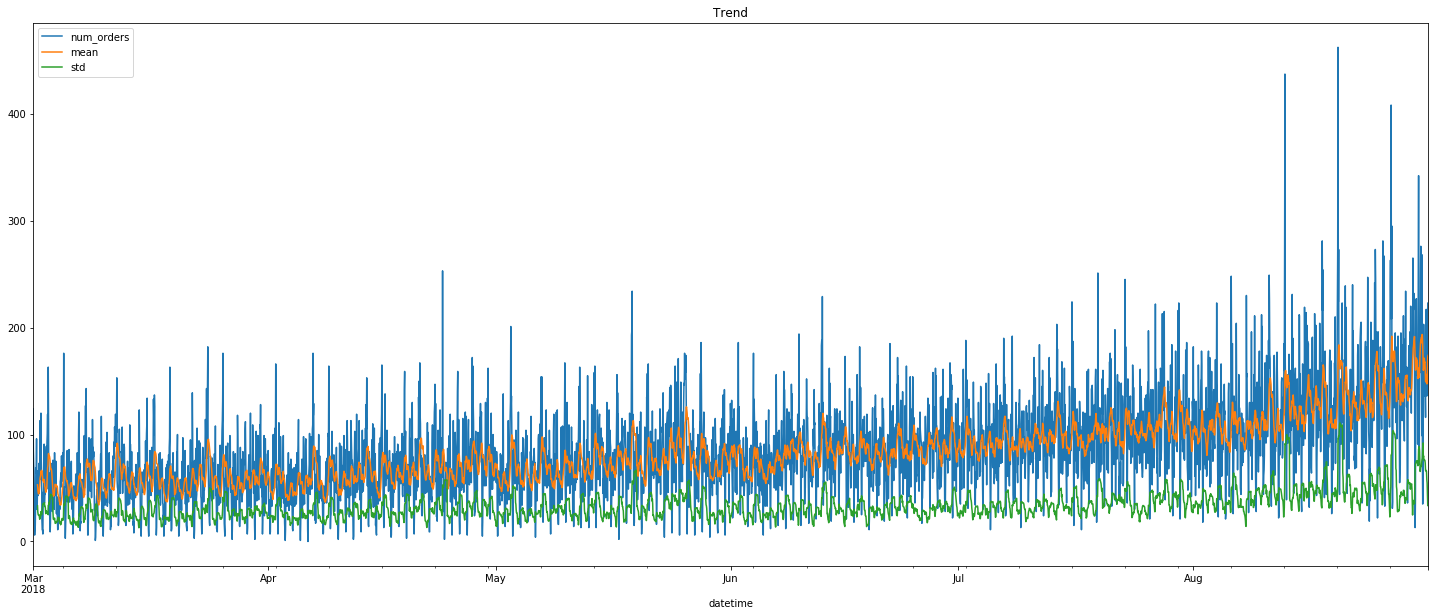

In [5]:
# Поменяем интервал временного ряда, сделаем его равным 1 часу
df = df.resample('1H').sum()
data_with_mean_std = df.copy()
data_with_mean_std['mean'] = df['num_orders'].rolling(15).mean()
data_with_mean_std['std'] = df['num_orders'].rolling(15).std()
data_with_mean_std.plot(figsize=(25,10), title='Trend')

На графике мы видим нестационарный временной ряд, т.к. его среднее и стандартное отклонение меняются.

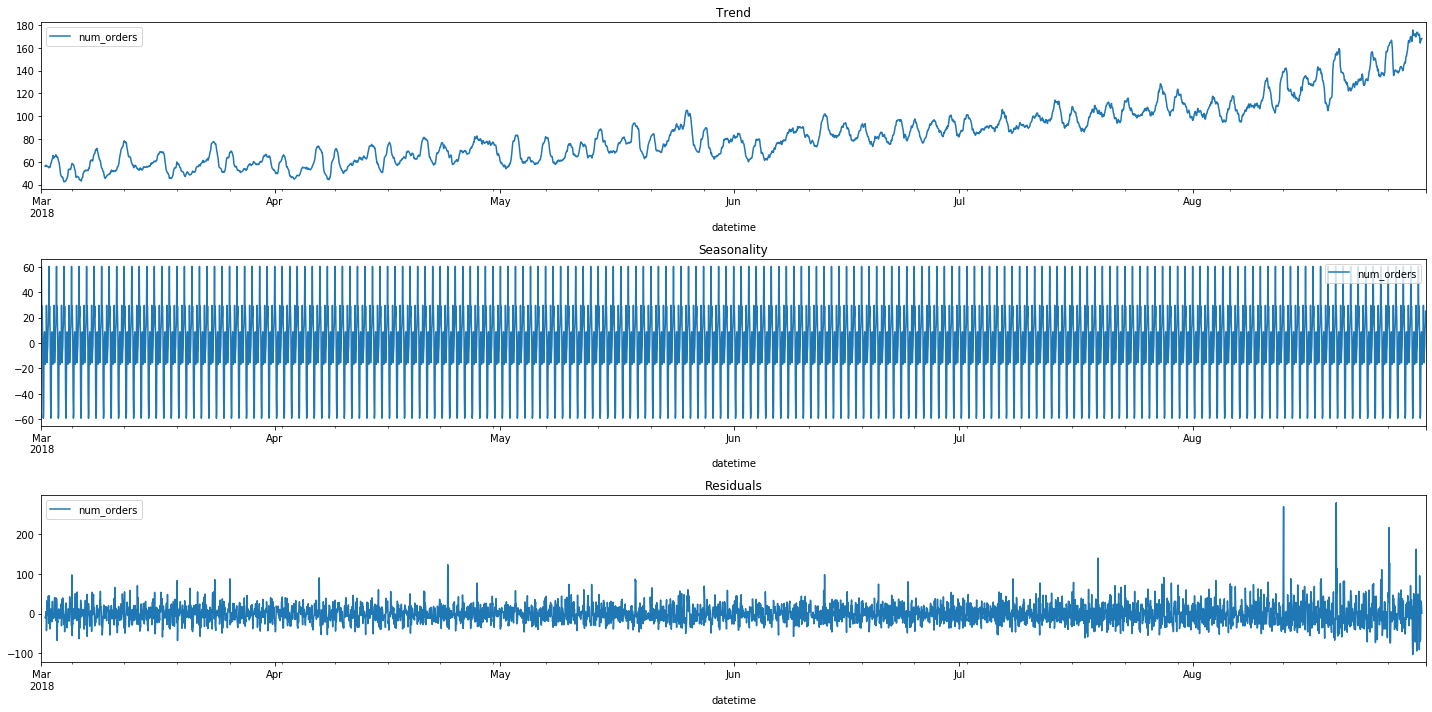

In [6]:
# Разложим временной ряд на тренд, сезонную компоненту и остатки
decomposed = seasonal_decompose(df)
plt.figure()
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Графики перегружены, рассмотрим данные за один месяц

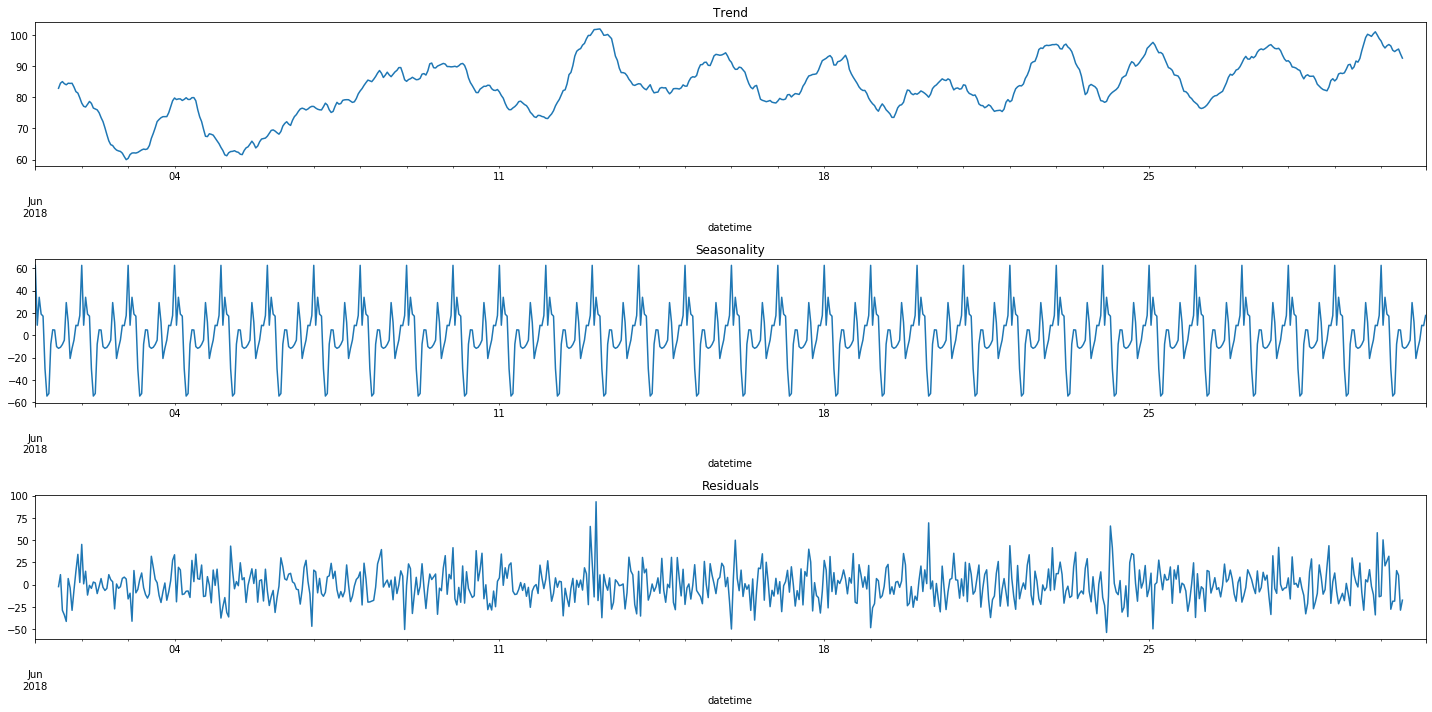

In [7]:
decomposed_june= seasonal_decompose(df['2018-06':'2018-06']['num_orders'])
plt.subplot(311)
decomposed_june.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_june.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_june.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Рассмотрим данные за первую неделю июня

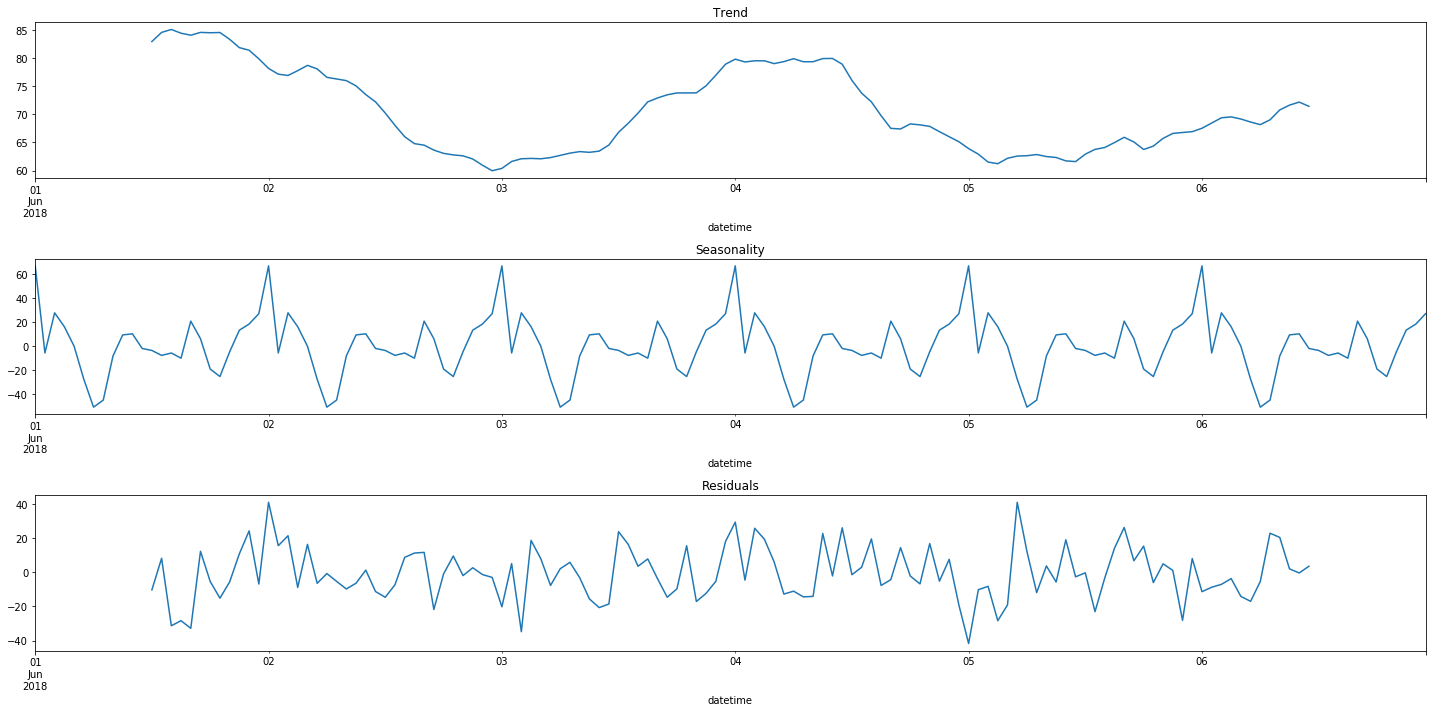

In [8]:
decomposed_june= seasonal_decompose(df['2018-06-01':'2018-06-06']['num_orders'])
plt.subplot(311)
decomposed_june.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_june.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_june.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

#### Вывод

В результате анализа данных и декомпозиции временного ряда на составляющие выяснено, что данные имеют явный тренд, среднее количество заказов увеличивается с течением времени. Так же в данных наблюдается сезонность в зависимости от времени суток. 

### Предобработка данных

#### Предобработка данных

In [9]:
# Создадин класс по добавлению признаков
class MakeFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self,
                 max_lag,
                 rolling_mean_size,
                 target,
                 month=True,
                 day=True,
                 dayofweek=True,
                 hour=True):
        
        self.max_lag = max_lag
        self.rolling_mean_size = rolling_mean_size
        self.month = month
        self.day = day
        self.dayofweek = dayofweek
        self.hour=hour
        self.target =target
        
        self.lag_ = defaultdict()
        
      
        
    def fit(self, X, y=None):
        
        self.X_ = X.drop(columns=self.target)
        self.y_ = X[self.target]
        
        return self
            
    
    
    def transform(self, X):

        temp = X.copy()
        
       
        for l in range(self.max_lag):
            temp['lag_'+str(l)] = temp[self.target].shift(l+1)
            
        temp['rolling_mean'] = temp[self.target].shift().rolling(self.rolling_mean_size).mean()
        
        if self.month:
            temp['month'] = X.index.month           
        if self.day:
            temp['day'] = X.index.day
        if self.dayofweek:
            temp['dayofweek'] = X.index.dayofweek
        if self.hour:
            temp['hour'] = X.index.hour
            
        for l in  range(self.max_lag+1):
            temp.iloc[:l+1, l] = self.y_[-l-1:].values.T

        temp.loc[:self.rolling_mean_size, 'rolling_mean'] = \
        self.y_[-self.rolling_mean_size:].values.T
        
        temp = temp.drop(columns=self.target)

        return temp

In [10]:
# Применим предобработку к данным
maker = MakeFeatures(24, 1, 'num_orders')

X = df
y = df['num_orders']

X = maker.fit_transform(X)

#### Разбиение на выборки

In [11]:
# Поделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

print('Размер обучающего набора данных: ', X_train.shape)
print('Размер тренировочного набора данных: ', X_test.shape)

print('Границы временного диапозона тренировочного набора данных: ' ,X_train.index.min(), X_train.index.max())
print('Границы временного диапозона тестового набора данных: ' ,X_test.index.min(), X_test.index.max())

Размер обучающего набора данных:  (3974, 29)
Размер тренировочного набора данных:  (442, 29)
Границы временного диапозона тренировочного набора данных:  2018-03-01 00:00:00 2018-08-13 13:00:00
Границы временного диапозона тестового набора данных:  2018-08-13 14:00:00 2018-08-31 23:00:00


In [12]:
# Функция расчета метрики root mean squared error
def rmse(y_true, y_pred):
    return round(mean_squared_error(y_true, y_pred)**0.5, 2)

rmse_score = make_scorer(rmse, greater_is_better=False)

#### Вывод

Реализован класс для формирования новых признаков на основании выявленных особенностей в данных. Для проверки базовых моделей выбран лаг 24 - что отражает суточную сезонность. Далее лаг будет подбираться. 

### Построение моделей

#### Константная модель

Запуск константной модели для возможности проверки последующих моделей на адекватность. Предсказание - медиана обучающей выборки

In [13]:
# Напишем класс константной модели
class ConstantModel:
    
    def fit(self, y_train):
        self.median = y_train.median()

    def predict(self, X_test):
        return np.ones(len(X_test)) * self.median

In [14]:
# Инициализируем и обучаем модель
model_const = ConstantModel()
model_const.fit(y_train)

# Получаем предсказания на тестовой выборке
predict_const = model_const.predict(X_test)

# Проверяем метрику получившейся модели
rmse_const = rmse(y_test, predict_const)
print('RMSE константной модели на тестовой выборке:', rmse_const)

RMSE константной модели на тестовой выборке: 87.15


#### Базовые модели

In [15]:
# Напишем функцию для возможности запуска нескольких базовых моделей 
def Model(features_train, target_train, features_test, target_test, model_info):
           
    model = model_info[0].fit(features_train, target_train)
    predict_train = model.predict(features_train)
    rmse_train = rmse(target_train, predict_train)
    predict = model.predict(features_test)
    rmse_result = rmse(target_test, predict)
    lst_results = [model_info[1], rmse_train, rmse_result]    
    
    return lst_results

In [16]:
# Напишем функцию start_model для запуска функции Model в цикле 
def start_model(features_train, target_train, features_test, target_test, model_list):
    
    table_models = []
    for model_info in model_list:
        start_time = time.time()
        lst_model = Model(features_train, target_train, features_test, target_test, model_info)
        time_model = round((time.time() - start_time),2)
        lst_model.append(time_model)
        table_models.append(lst_model)
        
    df_m = pd.DataFrame(data=table_models, columns=['model', '1_rmse_train', '2_rmse_test', 'time_model'])
    table = df_m.pivot_table(values=['1_rmse_train', '2_rmse_test', 'time_model'],    
                             index=['model'])
    
    return table    

In [17]:
# Осуществим вызов функции start_model для запуска базовых моделей
model_list = [[LinearRegression(), 'LinearRegression'],
              [Ridge(random_state=SEED), 'Ridge'], 
              [Lasso(random_state=SEED), 'Lasso'],
              [XGBRegressor(), 'XGBRegressor'],
              [LGBMRegressor(boosting_type='gbdt', random_state=SEED), 'LGBMRegressor']]

result = start_model(X_train, y_train, X_test, y_test, model_list)
result.sort_values(by='2_rmse_test', ascending=True)

[19:42:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,1_rmse_train,2_rmse_test,time_model
model,,,
LGBMRegressor,12.26,40.74,0.53
Lasso,25.87,46.17,0.49
XGBRegressor,19.73,46.38,0.74
LinearRegression,25.81,46.43,0.24
Ridge,25.81,46.43,0.01


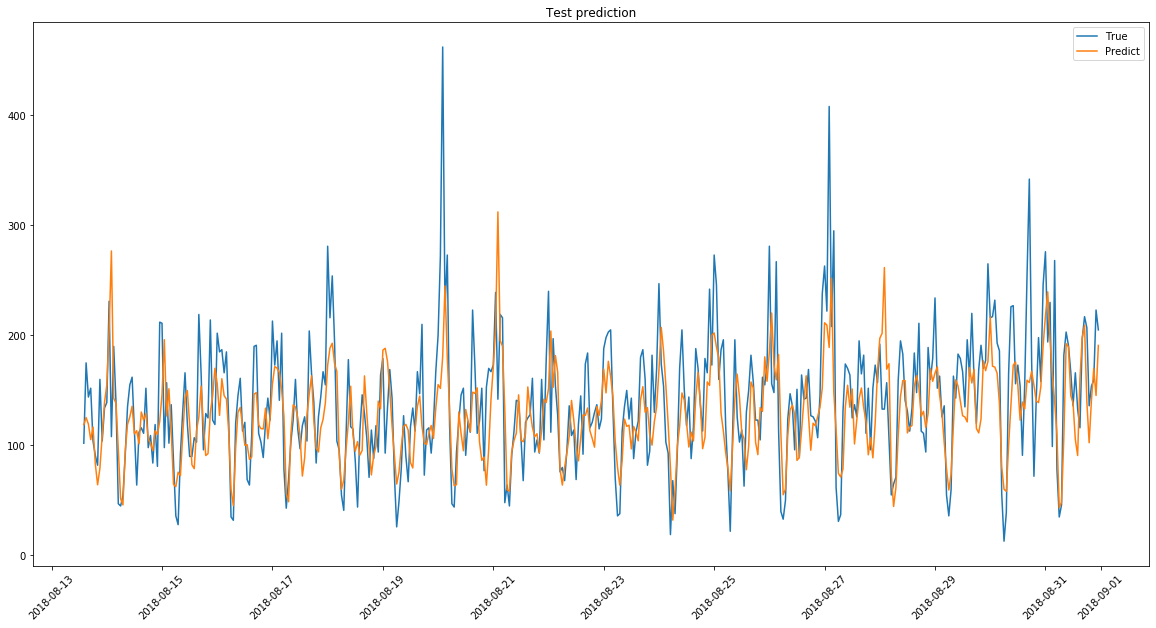

In [18]:
# Визуализируем предсказание лучшей модели и реальные данные  
model = Lasso()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.plot(y_test, label='True')
plt.plot(y_test.index, y_pred, label='Predict')
plt.xticks(rotation=45)
plt.title('Test prediction')
plt.legend()
plt.show()

#### Настройка гиперпараметров

In [19]:
# Поделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df, df['num_orders'], shuffle=False, test_size=0.1)

In [20]:
# Сформируем пайплайн
pipe = Pipeline([
    ('maker', MakeFeatures(24, 1, 'num_orders')),
    ('model', LGBMRegressor(boosting_type='gbdt', random_state=SEED, num_leaves=21))
])

params = [{
        'maker__max_lag': [168, 200],
        'maker__rolling_mean_size': [1, 10],
        'model': [Lasso(random_state=SEED)]
    }, {
        'maker__max_lag': [168, 200],
        'maker__rolling_mean_size': [1, 10],
        'model': [Ridge(random_state=SEED)]
    }, {
        'maker__max_lag': [168, 200],
        'maker__rolling_mean_size': [1, 10],
        'model': [LinearRegression()],
    }, {
        'maker__max_lag': [24, 48],
        'maker__rolling_mean_size': [20, 100],
        'model': [LGBMRegressor(boosting_type='gbdt', random_state=SEED, num_leaves=21)],
        'model__max_depth': [6, 11],
        'model__learning_rate': [0.015, 0.5]
    }, {
        'maker__max_lag': [24, 48],
        'maker__rolling_mean_size': [20, 100],
        'model': [XGBRegressor(random_state=SEED)],
        'model__max_depth': [6, 11],
        'model__learning_rate': [0.015, 0.5]
    }
]

In [21]:
# Запустим GridSearchCV
cv = TimeSeriesSplit(n_splits=2)
grid = GridSearchCV(pipe, param_grid=params, scoring=rmse_score, cv=cv, verbose=False)
grid = grid.fit(X_train, y_train)

[19:43:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:43:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [22]:
# Сгруппируем результаты GridSearchCV в таблицу
grid_results = pd.DataFrame(grid.cv_results_)
models = ['Lasso', 'Ridge', 'LinearRegression', 'LGBMRegressor', 'XGBRegressor']
cols = ['mean_fit_time', 'mean_score_time', 'mean_test_score']
res = pd.DataFrame(columns=cols)

for model in models:
    model_idx = grid_results['param_model'].astype('str').str.contains(model)
    best_fit = abs(grid_results[model_idx].sort_values(by='rank_test_score').head(1)[cols])
    res = res.append(best_fit)
    res.loc[best_fit.index, 'model'] = model
    
res.sort_values(by='mean_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,model
0,1.752690,0.509629,24.435,Lasso
4,0.525654,0.498361,24.475,Ridge
8,0.759743,0.479684,24.475,LinearRegression
19,0.291041,0.079532,29.245,LGBMRegressor
42,1.170792,0.118187,29.620,XGBRegressor


In [23]:
# Проверим лучшую модель на тестовом наборе данных
model = grid.best_estimator_
    
y_pred = model.predict(X_test)
print('RMSE на тестовом наборе данных:', rmse(y_test, y_pred))

RMSE на тестовом наборе данных: 38.92


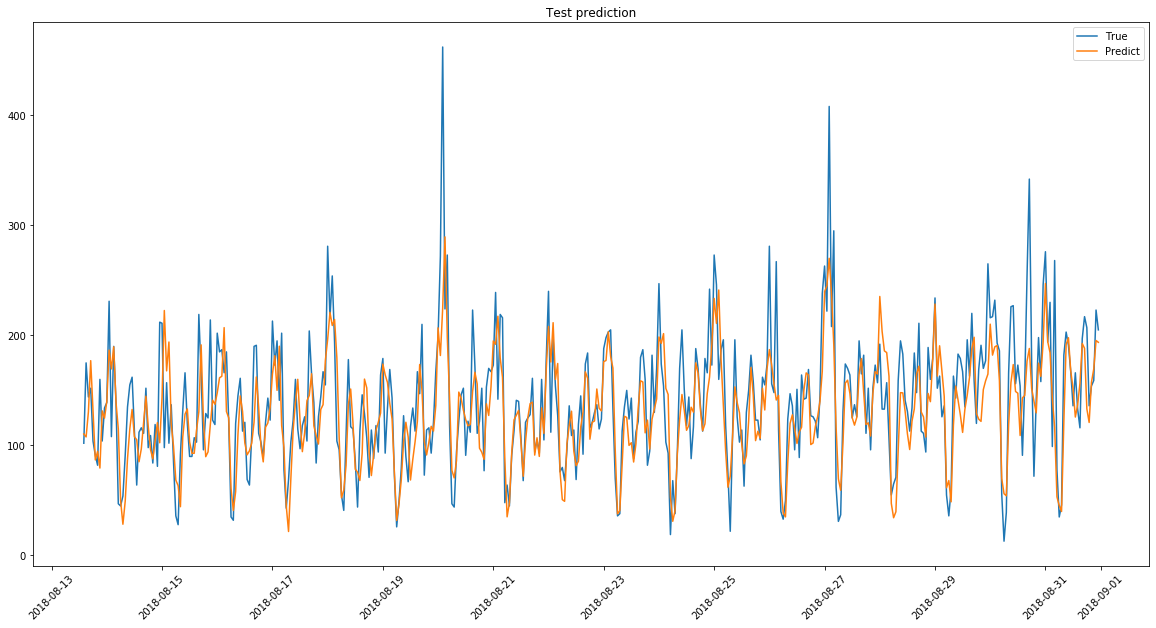

In [24]:
# Визуализируем предсказание лучшей модели и реальные данные
plt.plot(y_test, label='True')
plt.plot(y_test.index, y_pred, label='Predict')
plt.xticks(rotation=45)
plt.title('Test prediction')
plt.legend()
plt.show()

#### Вывод

Проверены базовые модели Lasso, Ridge, LinearRegression, LGBMRegressor, XGBRegressor.  
Для всех моделей произведен подбор параметров.  
Лучшие значения продемонстрировала модель Lasso.  

### Общий вывод

Анализ данных показал, что в данных отсутствуют пропуски и в датах присутствует монотонность периодов.   
Временной ряд нестационарен, с выраженным восходящим трендом и наличием сезонности (часовая, суточная, недельная).  
Т.к. данные предоставлены менее чем за один год, то сложно выявить причины появления тренда - принято решение не применять методы по его корректировке.  
Данные семплированы с периодичностью 1 час. Создана функция по генерации дополнительных признаков - отражение информации на основе даты (час, день, неделя, месяц), лаги разной длины и сглаживание (был произведен подбор оптимальных значений).  
В качестве первоначального шага были построены модели Lasso, Ridge, LinearRegression, LGBMRegressor, XGBRegressor с настройками по умолчанию. Выявлена закономерность, что на обучающих наборах данных лучшее качество продемонстрировали модели с бустингом, а на тестовом наборе данных - линейные.  
Следующим шагом был подбор оптимальных параметров для всех моделей.  
По результату лучшие результаты продемонстрировала линейная модель Lasso.  
Значение метрики RMSE на тестовом наборе данных: 38.92, что ниже, чем требуемый порог - 48.   
Так же для проверки моделей построена константная модель. Значение метрики константной модели 87.15, что подтверждает адекватность победившей модели.